In [106]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def printVar (varname, var):

    print(varname)
    print(var)

def saveArray (name, array):

    pd.DataFrame(array).to_csv("savedVariables/" + name + ".csv", index=False, header=None)



In [1]:
0/1

0.0

In [107]:
# Solve the 2D Navier-Cauchy equation using a segregated finite volume method

# Define mesh geometry and boundary conditions

Lx = .01 #width of domain
Ly = .01 #height of domain

fac = 1
fac_2 = 0

tr_left_x = 0     #u boundary condition at the left boundary
tr_left_y =  0     #v boundary condition at the left boundary

tr_right_x = 0   #u boundary condition at the right boundary
tr_right_y = 0     #v boundary condition at the right boundary

tr_top_x = 0       #u boundary condition at the top boundary
tr_top_y = 0      #v boundary condition at the top boundary

tr_bottom_x = 0    #u boundary condition at the bottom boundary 
tr_bottom_y = 0   #v boundary condition at the bottom boundary

nx = 8       #number of control volumes in the x-direction
ny = 8         #number of control volumes in the y-direction


In [108]:
u_left = -0.1      #u boundary condition at the left boundary
v_left = 0      #v boundary condition at the left boundary

u_right = 0.1    #u boundary condition at the right boundary
v_right = 0     #v boundary condition at the right boundary

u_top = 0      #u boundary condition at the top boundary
v_top = 0.1      #v boundary condition at the top boundary

u_bottom = 0    #u boundary condition at the bottom boundary 
v_bottom = - 0.1 

In [109]:
sys.path.append("../../Classes/")

from index_and_direction import dim

# dim().nx = 9
# dim().ny = 9

print(dim().nx)

8


In [110]:
print(dim().nx)

8


In [111]:
from index_and_direction import index
from index_and_direction import boundary_point_index
from index_and_direction import cell_index
from index_and_direction import displacement

In [112]:
# Define material properties

rho = 8050         #density of steel in kg/m^3
mu = 78*10e9       #shear modulus in Pa
K = 1.6*10e11      #bulk modulus in Pa

Lambda = K - (2/3)*mu

#print(Lambda)

In [113]:
## Define required variables

tf = 0.01           #total time in seconds
dx = Lx/nx          #length of each control volume in the x-direction
dy = Ly/ny          #length of each control volume in the y-direction
dt = tf/10          #size of time steps
Sfx = dy            #area vector x component (Area of East and West Faces)
Sfy = dx            #area vector y component (Area of North and South Faces)


In [114]:
## Define  position and time vectors

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
x = np.zeros((1,nx+2))   #position vector defining the center points of the control volumes in the x-direction.
x[0,nx+1] = Lx
x[0,1:nx+1] = np.arange(dx/2,Lx,dx)

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
y = np.zeros((1,ny+2))   #position vector defining the center points of the control volumes in the y-direction.
y[0,ny+1] = Ly
y[0,1:ny+1] = np.arange(dy/2,Ly,dy)

In [115]:
## Define required displacement matrices and b vector

u_new = np.zeros([(ny+2)*(nx+2),2])         #unknown displacements at t + 1    (Column 1 = x, Column2 = y)
u_old = np.zeros([(ny+2)*(nx+2),2])         #displacement at time t
u_old_old = np.zeros([(ny+2)*(nx+2),2])     #displacement at time t - 1

#rhs vector
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

## X equation:

In [116]:
class A(index, displacement):

    val = "value that stays in class without changning with instance"

    def __init__(self, xy):

        if xy == "x":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfx)/dx + ((2*mu)*Sfy)/dy
            self.a_N = + A.coef(xy, "N", "u")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "u")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "u")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "u")*(Sfx)/dx

        if xy == "y":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfy)/dy + ((2*mu)*Sfx)/dx 
            self.a_N = + A.coef(xy, "N", "v")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "v")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "v")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "v")*(Sfx)/dx

    def createMatrix(self):

        A_no_boundary = np.zeros([(ny+2)*(nx+2), (ny+2)*(nx+2)])
        # A_no_boundary = csr_matrix(A_no_boundary)  

        for j in np.arange(2, ny):     

            for k in np.arange((j*(nx+2)+2), (j*(nx+2)+nx)):  
                
                A_no_boundary[k,k] = self.a_P
                A_no_boundary[k,index(k).n] = -self.a_N
                A_no_boundary[k,index(k).s] = -self.a_S
                A_no_boundary[k, index(k).e] = -self.a_E
                A_no_boundary[k, index(k).w] = -self.a_W

        return A_no_boundary

    # b temporal term
    def b_temp(u_old, u_old_old, k, xy):

        if xy == "x":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy)
        if xy == "y":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
        
        return b_temporal_term
    
    def b_diff(k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"

        b_diffusion = (
                                Sfy*A.coef(xy, "N", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("NW", uv, u_previous, k))
                                    /dx)
                                + 
                                Sfy*A.coef(xy, "S", uv)*(
                                    (A.corner("SE", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dx)
                                +
                                Sfx*A.coef(xy, "E", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("SE", uv, u_previous, k))
                                    /dy)
                                +
                                Sfx*A.coef(xy, "W", uv)*(
                                    (A.corner("NW", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dy)
        )

        return b_diffusion
    
    def corner(corner_placement, uv, u_previous, k):
        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            return (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            return (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            return (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            return (1/4)*(disp.P + disp.NW + disp.N + disp.W)


    
    def coef(xy, face, uv):
        # could have and statements
        if xy == "x":
            if face == "N":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "S":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu
            if face == "E":
                if uv == "u":
                    return 2*mu + Lambda
                if uv == "v":
                    return Lambda
            if face == "W":
                if uv == "u":
                    return - (2*mu + Lambda)
                if uv == "v":
                    return - Lambda

        elif xy == "y":
            if face == "N":
                if uv == "u":
                    return Lambda
                if uv == "v":
                    return 2*mu + Lambda
            if face == "S":
                if uv == "u":
                    return - Lambda
                if uv == "v":
                    return - (2*mu + Lambda)
            if face == "E":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "W":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu

u_previous = u_new

In [117]:
class edgeCellTraction(A):

    def __init__(self, side, xy):

        if side == "b":
            self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N + A(xy).a_S*0 + A(xy).a_E + A(xy).a_W
        elif side == "t":
            self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*0 + A(xy).a_S + A(xy).a_E + A(xy).a_W
        elif side == "l":
            self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N + A(xy).a_S + A(xy).a_E*0 + A(xy).a_W
        elif side == "r":
            self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N + A(xy).a_S + A(xy).a_E + A(xy).a_W*0

        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edge, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (edgeCellTraction.corner(edge, "NE", uv, u_previous, k) - edgeCellTraction.corner(edge, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (edgeCellTraction.corner(edge, "SE", uv, u_previous, k) - edgeCellTraction.corner(edge, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (edgeCellTraction.corner(edge, "NE", uv, u_previous, k) - edgeCellTraction.corner(edge, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (edgeCellTraction.corner(edge, "NW", uv, u_previous, k) - edgeCellTraction.corner(edge, "SW", uv, u_previous, k))
                        /dy)
                )

        if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
        if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
        if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
        if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
        if (edge == "l") & (xy == "x") : W_term =  Sfy*tr_left_x  
        if (edge == "l") & (xy == "y") : W_term =  Sfy*tr_left_y  
        if (edge == "r") & (xy == "x") : E_term =  Sfy*tr_right_x  
        if (edge == "r") & (xy == "y") : E_term =  Sfy*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edge, corner_placement, uv, u_previous, k):
        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        if (edge == "b") & (corner_placement == "SE"):
            corner =  (1/2)*(disp.SE + disp.S)
        if (edge == "b") & (corner_placement == "SW"):
            corner =  (1/2)*(disp.SW + disp.S)

        if (edge == "t") & (corner_placement == "NE"):
            corner =  (1/2)*(disp.NE + disp.N)
        if (edge == "t") & (corner_placement == "NW"):
            corner =  (1/2)*(disp.NW + disp.N)

        if (edge == "l") & (corner_placement == "NW"):
            corner =  (1/2)*(disp.NW + disp.W)
        if (edge == "l") & (corner_placement == "SW"):
            corner =  (1/2)*(disp.SW + disp.W)

        if (edge == "r") & (corner_placement == "NE"):
            corner =  (1/2)*(disp.NE + disp.E)
        if (edge == "r") & (corner_placement == "SE"):
            corner =  (1/2)*(disp.SE + disp.E)


        
        return corner

# edgeCellTraction.b_diff("b", 14, "x", u_previous)
   

In [118]:
class boundaryCellTraction(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 0
            if edge == "t": sw_N = 0
            if edge == "l": sw_W = 0
            if edge == "r": sw_E = 0
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "SE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "NW", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
            if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
            if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
            if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
            if (edge == "l") & (xy == "x") : W_term =  Sfy*tr_left_x  
            if (edge == "l") & (xy == "y") : W_term =  Sfy*tr_left_y  
            if (edge == "r") & (xy == "x") : E_term =  Sfy*tr_right_x  
            if (edge == "r") & (xy == "y") : E_term =  Sfy*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [119]:
class boundaryPointTraction(A):

    def __init__(self, edge, xy):
        
        sw_S, sw_N, sw_W, sw_E = 0, 0, 0, 0

        for edge in edge:
            if edge == "b": sw_S = 1
            if edge == "t": sw_N = 1
            if edge == "l": sw_W = 1
            if edge == "r": sw_E = 1
        
        a_P = (A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W)*2/(Sfy)
        
        a_N = A(xy).a_N*2/(Sfy) 
        a_S = A(xy).a_S*2/(Sfy)
        a_E = A(xy).a_E*2/(Sfy)
        a_W = A(xy).a_W*2/(Sfy) 

        if edge == "b":
            self.a_N = a_P
            self.a_P = a_S
        if edge == "t":
            self.a_S = a_P
            self.a_P = a_N
        if edge == "l":
            self.a_E = a_P
            self.a_P = a_W
        if edge == "r":
            self.a_W = a_P
            self.a_P = a_E

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "E", uv, u_previous, k) - boundaryCellTraction.corner(edges, "W", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "E", uv, u_previous, k) - boundaryCellTraction.corner(edges, "W", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "N", uv, u_previous, k) - boundaryCellTraction.corner(edges, "W", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "N", uv, u_previous, k) - boundaryCellTraction.corner(edges, "W", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : b_diffusion =  Sfy*tr_bottom_x  + S_term
            if (edge == "b") & (xy == "y") : b_diffusion =  Sfy*tr_bottom_y  + S_term
            if (edge == "t") & (xy == "x") : b_diffusion =  Sfy*tr_top_x + N_term
            if (edge == "t") & (xy == "y") : b_diffusion =  Sfy*tr_top_y + N_term
            if (edge == "l") & (xy == "x") : b_diffusion =  Sfy*tr_left_x + W_term
            if (edge == "l") & (xy == "y") : b_diffusion =  Sfy*tr_left_y + W_term
            if (edge == "r") & (xy == "x") : b_diffusion =  Sfy*tr_right_x + E_term
            if (edge == "r") & (xy == "y") : b_diffusion =  Sfy*tr_right_y + E_term    

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        for edge in edges:
            if (edge == "b") & (corner_placement == "E"):
                corner =  (1/2)*(disp.E + disp.P)
            if (edge == "b") & (corner_placement == "W"):
                corner =  (1/2)*(disp.W + disp.P)

            if (edge == "t") & (corner_placement == "E"):
                corner =  (1/2)*(disp.E + disp.P)
            if (edge == "t") & (corner_placement == "W"):
                corner =  (1/2)*(disp.W + disp.P)

            if (edge == "l") & (corner_placement == "N"):
                corner =  (1/2)*(disp.N + disp.P)
            if (edge == "l") & (corner_placement == "S"):
                corner =  (1/2)*(disp.S + disp.P)

            if (edge == "r") & (corner_placement == "N"):
                corner =  (1/2)*(disp.N + disp.P)
            if (edge == "r") & (corner_placement == "S"):
                corner =  (1/2)*(disp.S + disp.P)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [120]:
switch = True

In [121]:
## Time loop

!rm -r savedVariables
! mkdir savedVariables

for time in t:

    print("\nTime = " + str(time))
    
    # Set number of maximum iterations for convergence
    
    icorr = 1
    maxcorr = 100000

    # Make directory

    ! mkdir savedVariables/{time}
    
    while True:
    # for iteration in [1]:
            
        u_previous = u_new #store latest guess values

        A_x = A("x").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # k is the cell number

            xy = "x"

            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)

            #Bottom left corner coefficients
               
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_x[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #ae
                A_x[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)
                        )   

            #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_x[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)                        ) 

            # Top Left Corner Coeficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_x[k,k] = boundaryCellTraction(sides, xy).a_P
                
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #ae                
                A_x[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E
                
                b_x[k] =(
                            edgeCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)  
                        )
                
            # Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_x[k,k] = boundaryCellTraction(sides, xy).a_P

                #as
                A_x[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous) 
                        )
                
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = ["b"]

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N                
                #ae
                A_x[k, index(k).e] = - boundaryCellTraction(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )                                 

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = ["t"]

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S                   
                #ae
                A_x[k, index(k).e] = - boundaryCellTraction(side, xy).a_E  
                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(side, xy).a_W  

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )
            
            # Center Left Boundaries

            elif  cell_index().center_left(k):
                side = ["l"]

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #ae
                A_x[k,index(k).e] = - boundaryCellTraction(side, xy).a_E

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = ["r"]

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #aw
                A_x[k,index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):
                edges = ["b"]

                #print(str(k) +  ": Bottom points")

                #ap
                A_x[k,k] = boundaryPointTraction(edges, "x").a_P

                #an
                A_x[k,index(k).n] = - boundaryPointTraction(edges, "x").a_N

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        (mu/(2*dx))*(
                                        + V.E
                                        - V.W
                                    )
                        ) 

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_bottom 


            # Center Top

            elif boundary_point_index().center_top(k):
                edges = ["t"]
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_x[k,k] = boundaryPointTraction(edges, "x").a_P

                #as
                A_x[k,index(k).s] = - boundaryPointTraction(edges, "x").a_S

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        (mu/(2*dx))*(
                                        - V.E
                                        + V.W
                                    )
                        ) 

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_top 

                
            # Center Left

            elif boundary_point_index().center_left(k):
                edges = ["l"]

                # #print( str(k) + ": Left points" )

                #ap
                A_x[k,k] = boundaryPointTraction(edges, "x").a_P

                #ae
                A_x[k,index(k).e] = - boundaryPointTraction(edges, "x").a_E

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        (Lambda/(2*dy))*(
                                        + V.N
                                        - V.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_left


            # Center Right

            elif boundary_point_index().center_right(k):
                edges = ["r"]

                #print( str(k) + ": Right points" )

                #ap
                A_x[k,k] = boundaryPointTraction(edges, "x").a_P

                #aw
                A_x[k,index(k).w] = - boundaryPointTraction(edges, "x").a_W

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        (Lambda/(2*dy))*(
                                        - V.N
                                        + V.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_right

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                # print( str(k) + ": Bottom Left: Bottom points" )
                
                # ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,index(k).n] = -2*mu/dy

                #b
                b_x[k] =(
                            tr_bottom_x
                            +
                            ((mu)/(2*dx))*(
                                            + V.E
                                            + V.P
                                            - 2*V.W
                                        )
                        ) 

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_bottom

            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k, index(k).e] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )
                
                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_left
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k, index(k).w] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                        - V.N
                                        - V.P
                                        + 2*V.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_right

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,index(k).n] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        ((mu)/(2*dx))*(
                                        + V.E
                                        + V.P
                                        - 2*V.W
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_bottom

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k, index(k).e] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_left

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,index(k).s] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                        - V.E
                                        - V.P
                                        + 2*V.W
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_top

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k, index(k).w] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                                - V.N
                                                - V.P
                                                + 2*V.S
                                            )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_right

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,index(k).s] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                            - V.E
                                            - V.P
                                            + 2*V.W
                                    )
                        ) 


                if switch:

                    A_x[k,k] = 1
                    b_x[k] = u_right

            # Corner Points

            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).ne] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["n", "ne"])] = 1
                A_x[k,index(k).dir(["ne", "ne"])] = 1
                A_x[k,index(k).dir(["e", "ne"])] = 1

                b_x[k] = 0

                # A_x[k,k] = 1
                # b_x[k] = 1e-100



            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).nw] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["n", "nw"])] = 1
                A_x[k,index(k).dir(["nw", "nw"])] = 1
                A_x[k,index(k).dir(["w", "nw"])] = 1

                b_x[k] = 0

                A_x[k,k] = 1
                b_x[k] = 1e-25

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).se] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["s", "se"])] = 1
                A_x[k,index(k).dir(["se", "se"])] = 1
                A_x[k,index(k).dir(["e", "se"])] = 1

                b_x[k] = 0

                # A_x[k,k] = 1
                # b_x[k] = 1e-100

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).sw] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["s", "sw"])] = 1
                A_x[k,index(k).dir(["sw", "sw"])] = 1
                A_x[k,index(k).dir(["w", "sw"])] = 1

                b_x[k] = 0

                # A_x[k,k] = 1
                # b_x[k] = 1e-25
                
            else:

                # print(str(k) + ": NO BC Cell")

                b_x[k] = (
                            A.b_temp(u_old, u_old_old, k, "x")
                            +
                            A.b_diff(k, "x", u_previous)
                        )

        # saveArray(str(time) + "/A_x_" + str(icorr) , A_x.todense())   
        # saveArray(str(time) + "/b_x_" + str(icorr), b_x)  

        ## Solve the x-equation
        
        Ux = spsolve(A_x, b_x)
        Ux = np.array(Ux)

        # #print(Ux)

        saveArray(str(time) + "/Ux_" + str(icorr), Ux)
        
        ## Prepare matrix A and b vector for the y-equation
        
        A_y = A("y").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number

            xy = "y"


            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)
 
            #Bottom left corner coefficients
            
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)
                        )   

                   #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)   
                        )
                     
            #Top left corner coefficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P
                
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #ae                
                A_y[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E
                
                b_y[k] =(
                            edgeCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)  
                        )
                
            #Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #as
                A_y[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous) 
                        )
            
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = ["b"]

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N                
                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(side, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )                                 

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = ["t"]

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S                   
                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(side, xy).a_E  
                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(side, xy).a_W  

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Left Boundaries

            elif  cell_index().center_left(k):
                side = ["l"]

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #ae
                A_y[k,index(k).e] = - boundaryCellTraction(side, xy).a_E

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = ["r"]

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #aw
                A_y[k,index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )


            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):

                #print(str(k) +  ": Bottom points")

                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        (Lambda/(2*dx))*(
                                        + U.E
                                        - U.W
                                    )
                        ) 

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_bottom 

            # Center Top

            elif boundary_point_index().center_top(k):
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,index(k).s] = - (4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        (Lambda/(2*dx))*(
                                        - U.E
                                        + U.W
                                    )
                        ) 


                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_top 
                
            # Center Left

            elif boundary_point_index().center_left(k):

                #print( str(k) + ": Left points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k, index(k).e] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        (mu/(2*dy))*(
                                        + U.N
                                        - U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_left

            # Center Right

            elif boundary_point_index().center_right(k):

                #print( str(k) + ": Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k, index(k).w] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        (mu/(2*dy))*(
                                        - U.N
                                        + U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_right

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                #print( str(k) + ": Bottom Left: Bottom points" )
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dx      

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dx

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((mu)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        ) 
                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_bottom

            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k, index(k).e] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_left
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k, index(k).w] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_right

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((Lambda)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_bottom

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_y[k,k] = 2*mu/dx

                #ae
                A_y[k, index(k).e] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_left

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,index(k).s] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_top

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_y[k,k] =  2*mu/dx

                #aw
                A_y[k, index(k).w] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_right

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_y[k,k] = (4*Lambda + 2*mu)/dy

                #as
                A_y[k,index(k).s] = -(4*Lambda + 2*mu)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        ) 

                if switch:

                    A_x[k,k] = 1
                    b_x[k] = v_right

            # # Corner Points
            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).ne] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["n", "ne"])] = 1
                A_y[k,index(k).dir(["ne", "ne"])] = 1
                A_y[k,index(k).dir(["e", "ne"])] = 1

                b_y[k] = 0

                # A_y[k,k] = 1
                # b_y[k] = 1e-100

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).nw] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["n", "nw"])] = 1
                A_y[k,index(k).dir(["nw", "nw"])] = 1
                A_y[k,index(k).dir(["w", "nw"])] = 1

                b_y[k] = 0

                # A_y[k,k] = 1
                # b_y[k] = 1e-25

            elif boundary_point_index().top_left_corner(k):
                # #print(str(k) + ": Top Left Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).se] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["s", "se"])] = 1
                A_y[k,index(k).dir(["se", "se"])] = 1
                A_y[k,index(k).dir(["e", "se"])] = 1

                b_y[k] = 0

                # A_y[k,k] = 1
                # b_y[k] = 1e-100

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).sw] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["s", "sw"])] = 1
                A_y[k,index(k).dir(["sw", "sw"])] = 1
                A_y[k,index(k).dir(["w", "sw"])] = 1

                b_y[k] = 0

                # A_y[k,k] = 1
                # b_y[k] = 1e-25


            else:

                #print(str(k) + ": NO BC Cell")

                b_y[k] = (
                            A.b_temp(u_old, u_old_old, k, "y")
                            +
                            A.b_diff(k, "y", u_previous)
                        )
        # saveArray(str(time) + "/A_y_" + str(icorr) , A_y)
        # saveArray(str(time) + "/b_y_" + str(icorr), b_y)       
                
        ## Solve the y-equation
        Uy = spsolve(A_y, b_y)
        Uy = np.array(Uy)

        saveArray(str(time) + "/Uy_" + str(icorr), Uy)
        
        # ## Update U.New with new x and y displacements

        u_new1 = np.vstack((Ux, Uy)).T
        saveArray (str(time) + "/U_new1_" + str(icorr), u_new1)    
        saveArray (str(time) + "/u_previous_" + str(icorr), u_previous)

        # # U.New[:,0] = Ux
        # # U.New[:,1] = Uy
        
        ## Calculate the residual of each iteration
        
        normFactor = np.max(u_new1)
        residual = math.sqrt(np.mean((u_new1 - u_previous)**2))/normFactor
        tolerance = 1e-2

        u_new = u_new1
    
        ##print out residual of each iteration
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))
             
        ## Convergence check
        
        if residual < tolerance:
            
            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1
    
        ## Relaxation
        # u_new1[:, 0] = u_new1[:, 0] - np.mean(u_new1[:, 0])
        # u_new1[:, 1] = u_new1[:, 1] - np.mean(u_new1[:, 1])
    	
        # alpha = 0.1
        # u_new1 = alpha*u_new1 + (1-alpha)*u_previous 

    
    ## Update variables
    u_old_old = u_old
    u_old = u_new1
    
    # ## Add the boundary conditions to the solution matrices
    u_reshape_x = u_new[:,0].reshape(nx+2, ny+2)
    u_reshape_y = u_new[:,1].reshape(nx+2, ny+2)
    
    # #Boundary conditions for u matrix
    U = np.zeros((nx+2,ny+2))
    V = np.zeros((nx+2,ny+2))
 
    U[:, :] = u_reshape_x
    V[:, :] = u_reshape_y 

    #Modulus of displacement

    disp_mod = np.sqrt((U**2) + (V**2))
    disp_mod_converted = disp_mod*1e6 #Convert displacement to micrometers
    
#     # ## Plot the results

    import plotly.graph_objects as go

    disp_mod = np.sqrt((U**2) + (V**2))*1e-10

    dispx, dispy = np.meshgrid(x, y)
    fig = go.Figure(data=[go.Surface(z=disp_mod_converted, x=dispx, y=dispy)]) 
    
fig.show()   

print("U graph")
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])

fig.show()   

print("V graph")
fig = go.Figure(data=[go.Surface(z=V, x=dispx, y=dispy)])

fig.show()  




Time = 0.0


/home/scottlevie/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



icorr = 1, Residual = 0.43156691254080176146, normFactor = 0.10000000000000000555
icorr = 2, Residual = 0.14054642323133972881, normFactor = 0.28717181019708298839
icorr = 3, Residual = 0.17883933703148008343, normFactor = 120800235251730.21875000000000000000
icorr = 4, Residual = 0.14757493909446511848, normFactor = 129337506893942.65625000000000000000
icorr = 5, Residual = 0.18043624214724654498, normFactor = 59902895683540269899068735488.00000000000000000000
icorr = 6, Residual = 0.12821106343144034190, normFactor = 82576349680300089563852832768.00000000000000000000
icorr = 7, Residual = 0.16102017623253775391, normFactor = 48667988821775600984740839588969494660251648.00000000000000000000
icorr = 8, Residual = 0.13286577015512576749, normFactor = 53850668373013089991767439994446487626973184.00000000000000000000
icorr = 9, Residual = 0.17633414561461463466, normFactor = 30890045693417781026101138326098214770269067598089106227200.00000000000000000000
icorr = 10, Residual = 0.134654865

/tmp/ipykernel_686/2292170111.py:1308: RuntimeWarning:

overflow encountered in square



icorr = 25, Residual = inf, normFactor = 431359270412487118118919995123312695500650786401065274121343064204535923747589334081099113974752934345138961540251287089767720929585791943072582865859388405205087130064600956928.00000000000000000000
icorr = 26, Residual = inf, normFactor = 431359270412487118118919995123312695500650786401065274121343064204535923747589334081099113974752934345138961540251287089767720929585791943072582865859388405205087130064600956928.00000000000000000000
icorr = 27, Residual = inf, normFactor = 323853420039963813213370597378440839411963002153318536087179046957152664188219790725631194501597154638829926678488109879578515872887960807483562050807610673231247845768870775961888674222702592.00000000000000000000
icorr = 28, Residual = inf, normFactor = 341923751346015062695074104933910625528775578609397857480400001857994355245502780409622531109562842574728848838891699470717538169114547541729547130835452005766850148019373355819371131465367552.00000000000000000000
icorr = 29

/tmp/ipykernel_686/2292170111.py:980: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:872: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1064: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1007: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1035: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:927: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:954: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1093: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1150: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:1122: RuntimeWarning:

overflow encountered in double_scalars

/tmp/ipykernel_686/2292170111.py:899: Runtim

icorr = 48, Residual = nan, normFactor = nan
icorr = 49, Residual = nan, normFactor = nan
icorr = 50, Residual = nan, normFactor = nan
icorr = 51, Residual = nan, normFactor = nan
icorr = 52, Residual = nan, normFactor = nan
icorr = 53, Residual = nan, normFactor = nan
icorr = 54, Residual = nan, normFactor = nan
icorr = 55, Residual = nan, normFactor = nan
icorr = 56, Residual = nan, normFactor = nan
icorr = 57, Residual = nan, normFactor = nan
icorr = 58, Residual = nan, normFactor = nan
icorr = 59, Residual = nan, normFactor = nan
icorr = 60, Residual = nan, normFactor = nan
icorr = 61, Residual = nan, normFactor = nan
icorr = 62, Residual = nan, normFactor = nan
icorr = 63, Residual = nan, normFactor = nan
icorr = 64, Residual = nan, normFactor = nan
icorr = 65, Residual = nan, normFactor = nan
icorr = 66, Residual = nan, normFactor = nan
icorr = 67, Residual = nan, normFactor = nan
icorr = 68, Residual = nan, normFactor = nan
icorr = 69, Residual = nan, normFactor = nan
icorr = 70

KeyboardInterrupt: 

In [ ]:
print(Ux)

[-5.57266260e-16 -5.26073156e-16 -1.32238920e-16  2.61165984e-16
  7.26899899e-16  1.31794274e-15  2.13208242e-15  4.04177409e-15
  3.87601292e-15  4.95373596e-14 -7.19244314e-16 -5.36295988e-16
 -1.79785362e-16  2.22489727e-16  6.84574178e-16  1.24526155e-15
  1.98551273e-15  3.01105090e-15  5.14764721e-15  1.68962066e-15
 -8.88512563e-16 -7.22749500e-16 -3.80702008e-16 -3.50348008e-17
  3.04763895e-16  6.10324786e-16  8.14961978e-16  8.02445765e-16
  2.97912780e-16  2.17556192e-15 -1.09626841e-15 -9.31805087e-16
 -6.06224520e-16 -2.91868918e-16 -1.04106374e-18  2.47222957e-16
  4.31871613e-16  5.61610644e-16  7.62845989e-16  9.97773626e-16
 -1.29449604e-15 -1.13306083e-15 -8.13179214e-16 -5.06424865e-16
 -2.20469963e-16  3.93127555e-17  2.77484458e-16  5.25195105e-16
  8.28935072e-16  1.03741665e-15 -1.46865147e-15 -1.30779660e-15
 -9.87384565e-16 -6.76502902e-16 -3.79068104e-16 -9.42958585e-17
  1.87096811e-16  4.86551135e-16  8.24378018e-16  1.00562174e-15
 -1.61585061e-15 -1.45454

In [ ]:
dispx.shape, dispy.shape, U.shape
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])
fig.show()

(100, 100)


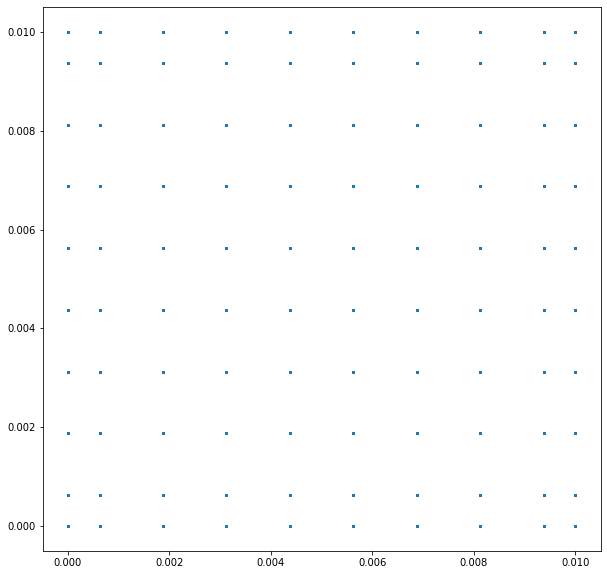

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))


# Displacement Scatter:

#
x_values = (dispx.reshape((nx+2)*(ny+2), 1) + u_new[:, 0])#*scale
y_values = (dispy.reshape((nx+2)*(ny+2), 1) + u_new[:, 1])#*scale

print(x_values.shape)

plt.scatter(x_values, y_values, s=1)

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100


array([[-5.5726626e-16],
       [ 6.2500000e-04],
       [ 1.8750000e-03],
       [ 3.1250000e-03],
       [ 4.3750000e-03],
       [ 5.6250000e-03],
       [ 6.8750000e-03],
       [ 8.1250000e-03],
       [ 9.3750000e-03],
       [ 1.0000000e-02]])

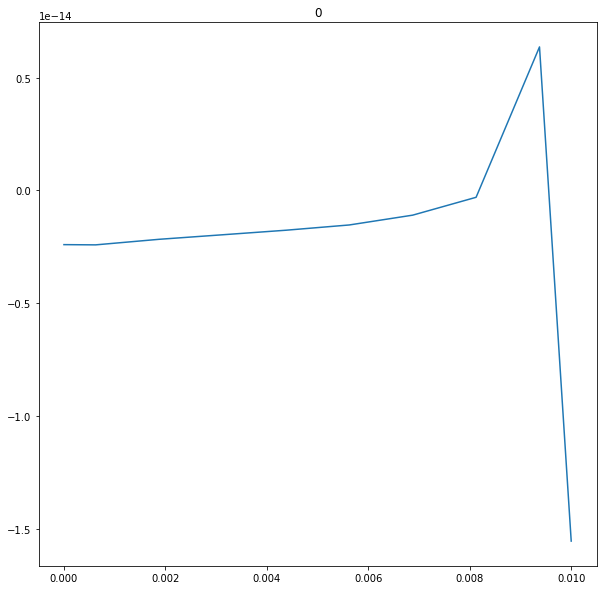

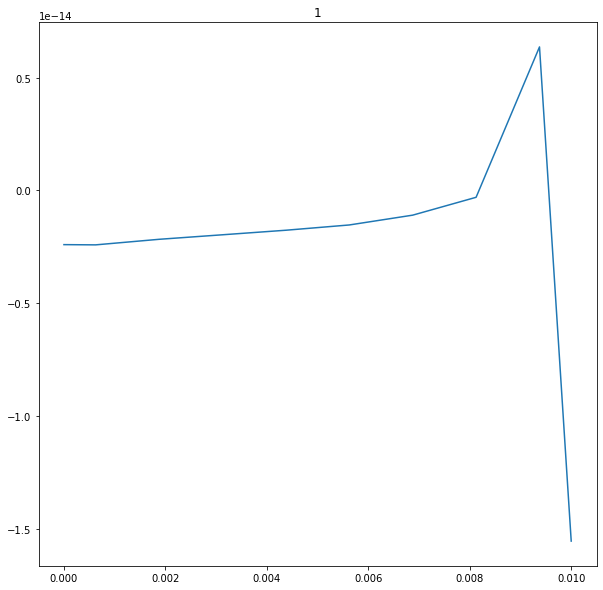

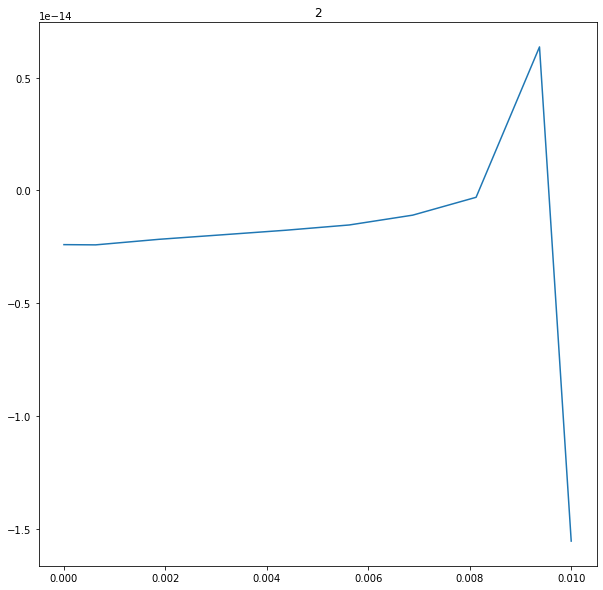

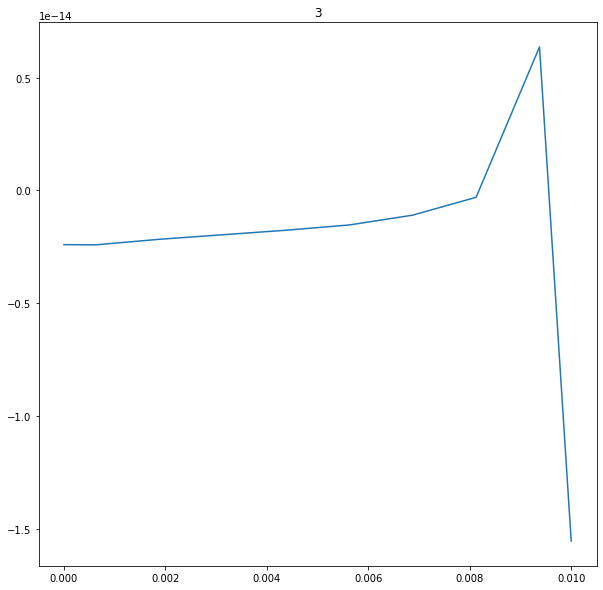

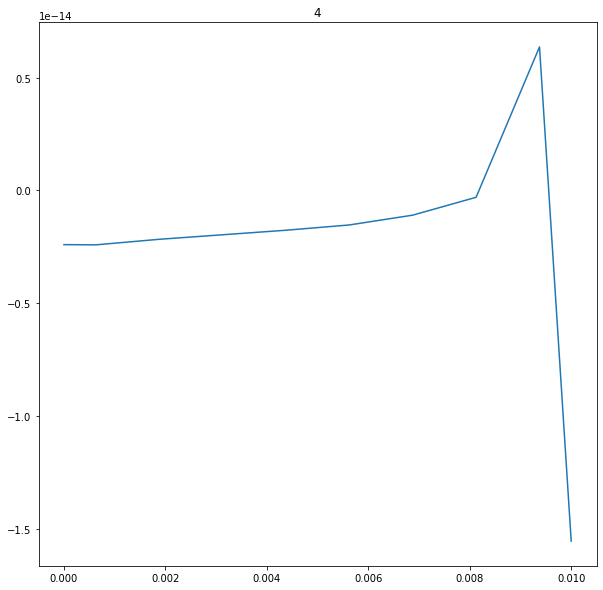

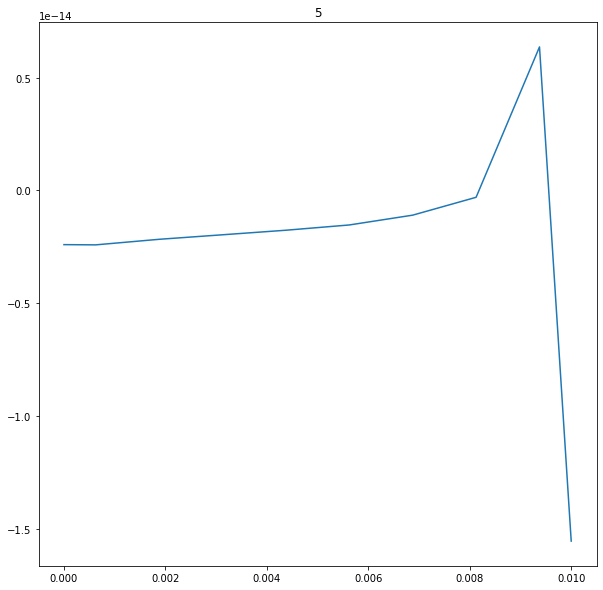

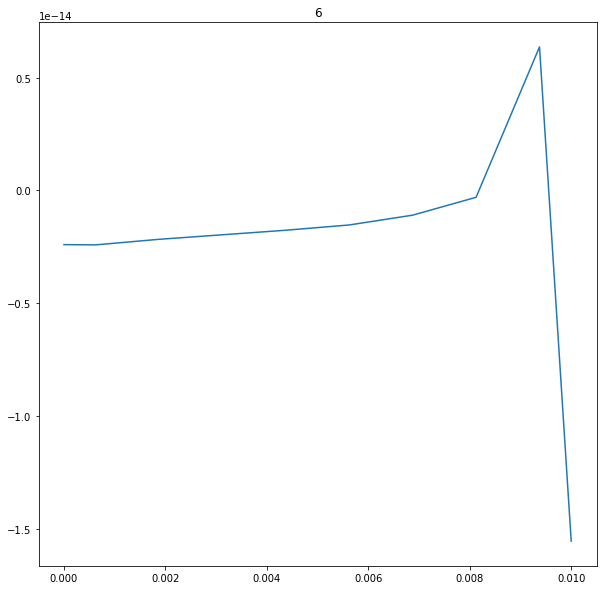

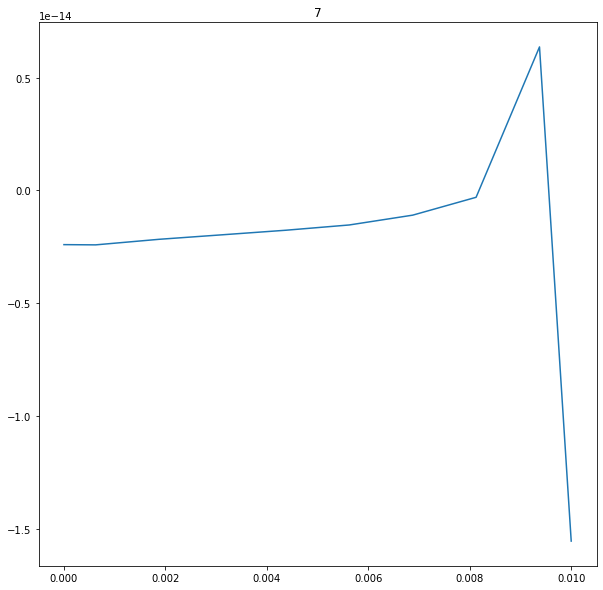

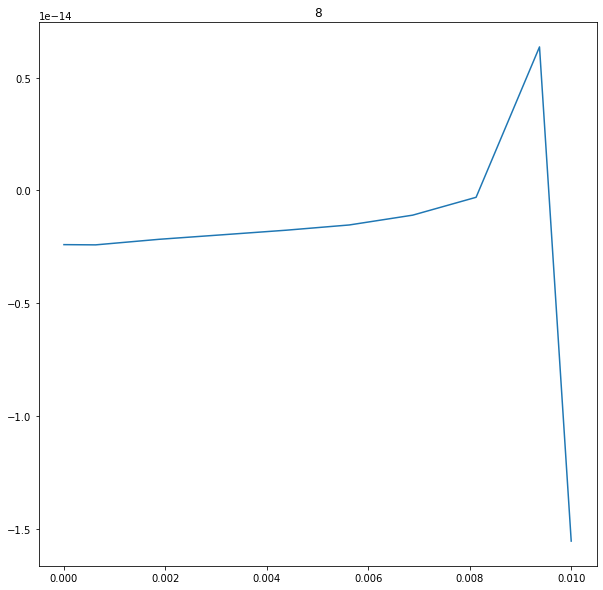

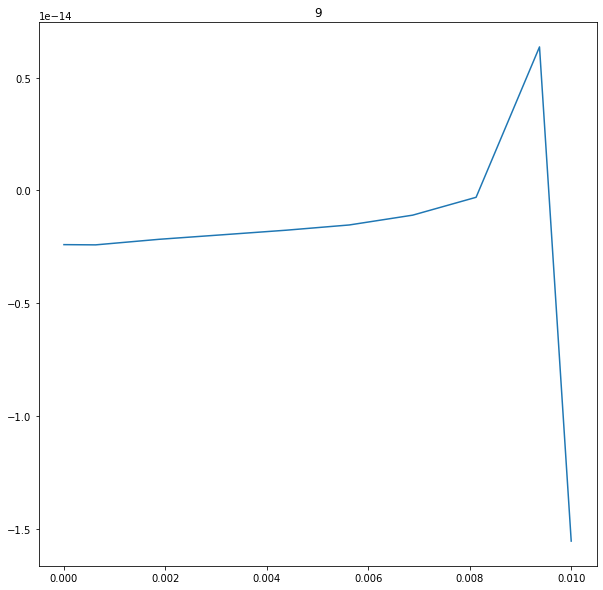

In [ ]:
for i in np.arange(0,ny+2):
    
    plt.figure(figsize=(10, 10))

    print(str(0+(i*10)), str(10+(i*10)))
    
    x_values = dispx.reshape((nx+2)*(ny+2), 1)[0+(i*10):10+(i*10)] + u_new[:,0].reshape((nx+2)*(ny+2), 1)[0:10]

    y_values = u_new[:,1].reshape((nx+2)*(ny+2), 1)[0:10]

    plt.plot(x_values, y_values)
    plt.title(str(i))

    plt.show

x_values

In [ ]:
u_new

array([[-5.57266260e-16, -2.40700785e-15],
       [-5.26073156e-16, -2.41730798e-15],
       [-1.32238920e-16, -2.17084869e-15],
       [ 2.61165984e-16, -1.97026234e-15],
       [ 7.26899899e-16, -1.76838891e-15],
       [ 1.31794274e-15, -1.53479112e-15],
       [ 2.13208242e-15, -1.09976092e-15],
       [ 4.04177409e-15, -3.07750593e-16],
       [ 3.87601292e-15,  6.36131159e-15],
       [ 4.95373596e-14, -1.55538356e-14],
       [-7.19244314e-16, -2.37196404e-15],
       [-5.36295988e-16, -2.21085301e-15],
       [-1.79785362e-16, -2.01750664e-15],
       [ 2.22489727e-16, -1.82643777e-15],
       [ 6.84574178e-16, -1.64974653e-15],
       [ 1.24526155e-15, -1.46068726e-15],
       [ 1.98551273e-15, -1.19259105e-15],
       [ 3.01105090e-15, -2.77032943e-16],
       [ 5.14764721e-15,  9.52880056e-16],
       [ 1.68962066e-15,  3.00660375e-14],
       [-8.88512563e-16, -2.01366231e-15],
       [-7.22749500e-16, -1.88708878e-15],
       [-3.80702008e-16, -1.68260235e-15],
       [-3.

In [ ]:
Ux[0], Ux[9], Ux[90], Ux[99]

(-5.572662596188541e-16,
 4.9537359579682166e-14,
 -1.9001462574615314e-15,
 5.755399096647622e-16)

In [ ]:
Uy[0], Uy[9], Uy[90], Uy[99]

(-2.4070078519055093e-15,
 -1.5553835551964768e-14,
 4.295613134005821e-16,
 1e-25)

In [ ]:
Ux[0] - Uy[0]

1.849741592286655e-15